# Unsupervised learning: Clustering & DimRed

**Кластеризация** - задача разбиения объектов на группы (кластеры). Кластеризация не использует правильные ответы при обучении(разметку), поэтому это задача *обучения без учителя*.<br>

**Задача кластеризации** -- разбить пространство объектов на группы таким образом, чтобы одинаковые объекты были в одной группе, а разные  -- в разных группах<br>

## Датасет ```winemag-data-130k-v2.csv```

In [1]:
# imports here
import pandas as pd
import numpy as np

#viz
import seaborn as sns
import matplotlib.pyplot as plt

# progress bar
from tqdm import tqdm

Открываем датасет и посмотрим на него

In [2]:
df = pd.read_csv('winemag-data-130k-v2.csv')

In [3]:
print(df.shape)
df.head(3)

(129971, 14)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


Удалим ненужный столбец:

In [4]:
df.drop(labels=["Unnamed: 0"], axis=1, inplace=True)

Визуализируем пропущенные значения:

<Axes: >

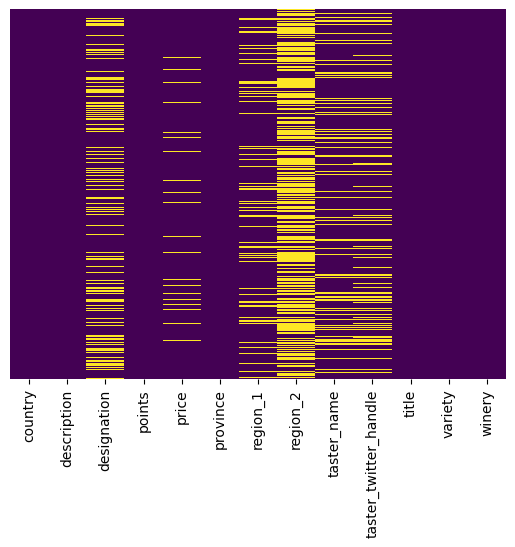

In [5]:
import seaborn as sns
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Удалим повторяющиеся строки:

In [6]:
df.drop_duplicates(inplace=True)

Данные: подготовим 2 датасета

1. оставим колонки с числовыми данными.
2. оставим колонки с числовыми данными + колонку 'country'

In [7]:
df_numerical = df.select_dtypes(include = [np.number]) #dataset 1
data = df[['country', 'points', 'price']] #dataset 2

Переведем категориальный признак 'country' в численный

In [8]:
pd.options.mode.chained_assignment = None
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data[["country_encoded"]] = data[["country"]].apply(le.fit_transform)
data.drop(labels=["country"], axis=1, inplace=True)

In [9]:
print(df_numerical.nunique())
print()
print(data.nunique())

points     21
price     390
dtype: int64

points              21
price              390
country_encoded     44
dtype: int64


Посмотрим на % отсутствующих значений:

In [10]:
print(df_numerical.isnull().sum() / df_numerical.shape[0] * 100)
print()
print(data.isnull().sum() / data.shape[0] * 100)

points    0.000000
price     6.996533
dtype: float64

points             0.000000
price              6.996533
country_encoded    0.000000
dtype: float64


Избавимся от строк с пропущенными значениями:

In [11]:
df_numerical.dropna(inplace=True)
data.dropna(inplace=True)

In [12]:
df_numerical.shape

(111593, 2)

In [13]:
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111593 entries, 1 to 129970
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   points  111593 non-null  int64  
 1   price   111593 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.6 MB


In [14]:
df_numerical.describe()

,points,price
count,111593.000000,111593.000000
mean,88.413969,35.620747
std,3.098767,42.103728
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


## Подготовка данных 

When the value of the skewness is positive, the tail of the distribution is longer towards the right hand side of the curve

In [15]:
df_numerical['price'].skew()

17.95996481928701

array([[<Axes: title={'center': 'price'}>]], dtype=object)

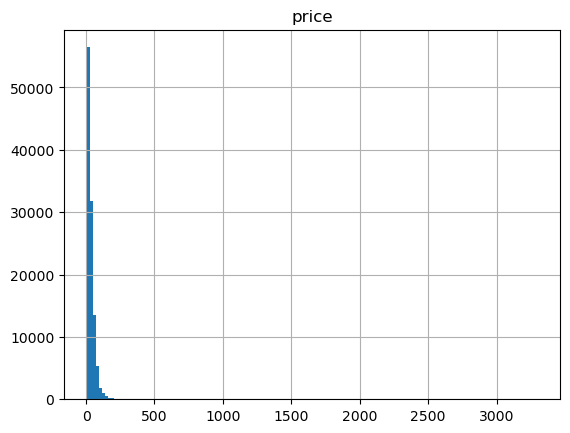

In [16]:
df_numerical.hist(column="price", bins=150)

In [17]:
df_numerical['points'].skew()

0.03963776852734602

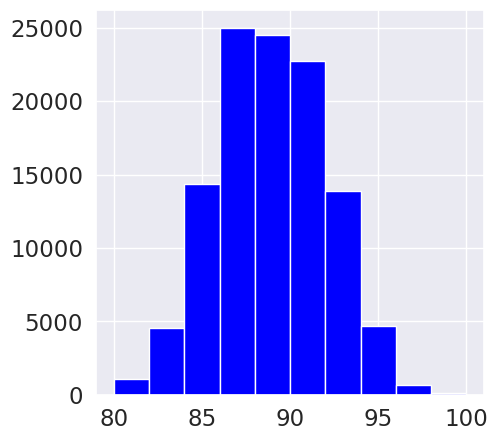

In [18]:
sns.set(font_scale=1.5, rc={'figure.figsize':(5,5)})
ax=df_numerical['points'].hist(color='blue')

Перемешаем данные:

In [19]:
from sklearn.utils import shuffle
df_numerical = shuffle(df_numerical)
data = shuffle(data)

Оставим только часть данных (иначе вычисления слишком "тяжелые")

In [20]:
df_numerical = df_numerical[:30000]
data = data[:30000]

В качестве основного алгоритма мы будем использовать K-means. Так как он использует дистанцию как основную метрику для определения данных в кластеры, давайте нормируем значения параметров, чтобы они определялись на едином промежутке

In [21]:
from sklearn.preprocessing import StandardScaler
# for datset 1
data_scaled = df_numerical.copy()
col_names = ['points', 'price']
features = data_scaled[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
data_scaled[col_names] = features

In [22]:
data_scaled.head(3)

,points,price
21984,-0.133778,-0.235294
87522,1.156064,1.077391
37684,-1.423621,-0.624238


In [23]:
# for dataset 2
data_scaled2 = data.copy()
col_names = ['points', 'price', 'country_encoded']
features = data_scaled2[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
data_scaled2[col_names] = features

In [24]:
data_scaled2.head(3)

,points,price,country_encoded
114162,0.818747,-0.371849,0.878318
92078,1.138887,1.953258,0.878318
59209,-1.102092,-0.569264,-0.495795


A еще можем нарисовать тепловую карту корреляций параметров:

<Axes: >

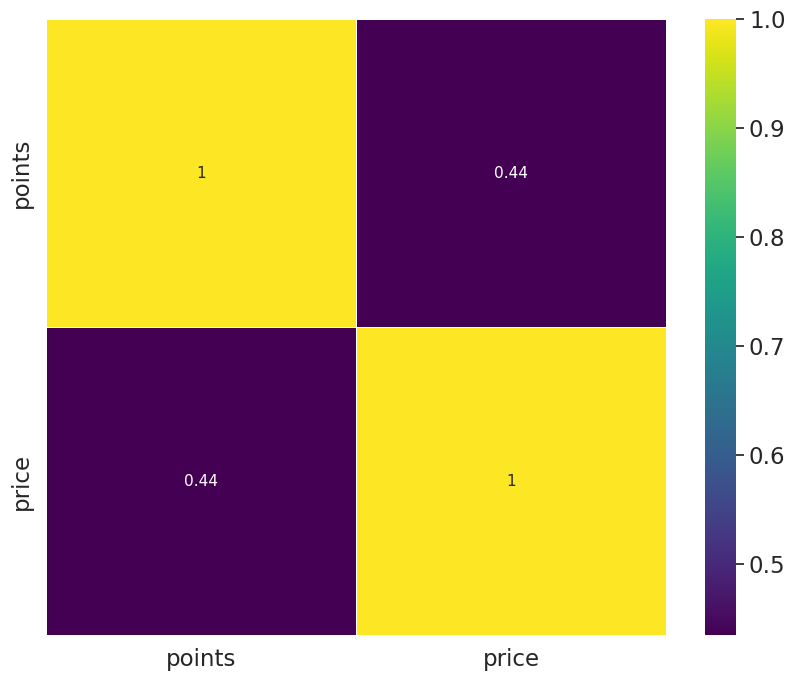

In [25]:
corr = data_scaled.corr()

plt.figure(figsize=(10,8))

sns.heatmap(corr, linewidths=.5, cmap='viridis', annot=True,annot_kws={"size": 11})

<Axes: >

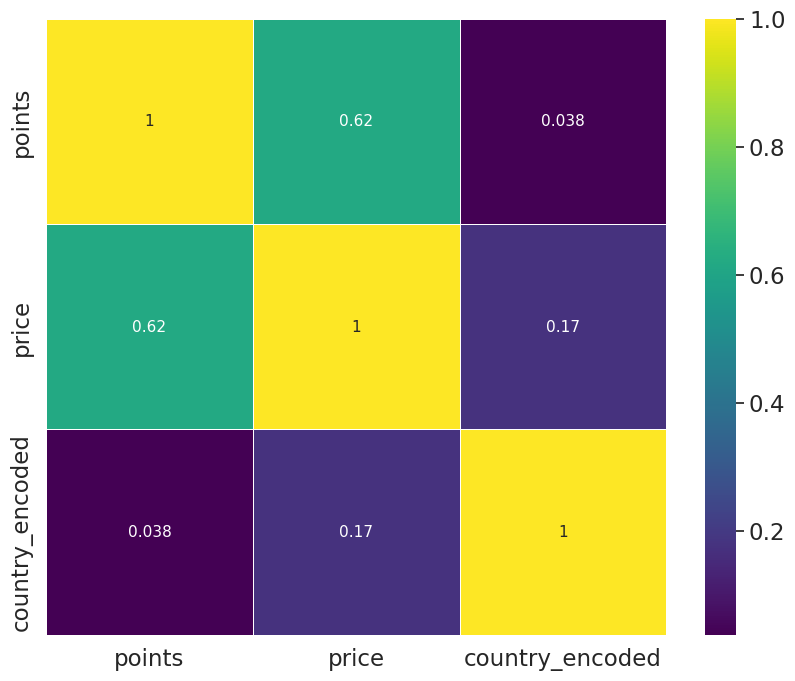

In [26]:
corr = data_scaled2.corr(method="spearman")

plt.figure(figsize=(10,8))

sns.heatmap(corr, linewidths=.5, cmap='viridis', annot=True,annot_kws={"size": 11})

## Кластеризация

[здесь можно почитать про основные алгоритмы](https://scikit-learn.org/stable/modules/clustering.html)

Сначала посчитаем *инерцию* (эта метрика считается как сумма квадратов ошибок для каждого кластера). Чем ниже значения инерции, тем более "плотные" получились кластеры, следовательно, тем лучше прошла кластеризация 

Проведем серию экспериментов на dataset 1 (где изначально только 2 числовых признака -- points и price):

In [27]:
# https://scikit-learn.org/stable/modules/clustering.html#k-means

import sklearn.cluster as cluster

# inertia = {} # сюда будем сохранять значения
inertia = []
for i in tqdm(range(2,20)): # значения интервала - число кластеров (можно изменять) 
    
    kmeans = cluster.KMeans(
               n_clusters=i, # инициализируем модель
               init='k-means++', # метод, как разбросать центры среди данных
               n_init=15, # сколько раз будем переопределять центры (в результате выберем самый успешный)
               max_iter=500, # количество итераций а один проход алгоритма
               random_state=17 # сколько раз датасет перемешан перед кластеризацией
    ) 
    
    
    kmeans.fit(data_scaled) # обучаем модель 
    inertia.append(kmeans.inertia_) # добавляем значения инерции для каждого числа кластеров
    # inertia.update({i:kmeans.inertia_}) 
    
# print(inertia)

100%|███████████████████████████████████████████| 18/18 [00:04<00:00,  4.05it/s]


In [28]:
for i in inertia:
    print(i)

36097.95320727729
24456.645053775916
18319.750535057454
14393.597741530952
12070.288044464502
9921.868708676804
8619.721974576672
7392.782078433741
6527.482686783636
5783.303276836024
5201.520945645138
4731.686651928363
4317.0851257828535
3960.911097849302
3739.8842444641127
3526.3714900906716
3292.682917737218
3117.7304922483745


Следующая метрика -- силуэты. Чем больше значение, тем лучше прошла кластеризация

Силуэты считаются как отношение среднего внутри кластера $a$ и среднего к ближайшему кластеру $b$ для каждой точки. $Silhouette Coefficient = \frac{(b - a) }{ max(a, b)}$

In [29]:
from sklearn.metrics import silhouette_score

# все как в предыдущей ячейке, только силуэт-скоры сохраняем как значения в словаре
silhouette = {}
for i in tqdm(range(2,20)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(data_scaled)
    
    silhouette[i] = silhouette_score(data_scaled, kmeans.labels_)

100%|███████████████████████████████████████████| 18/18 [02:15<00:00,  7.52s/it]


In [30]:
print(silhouette)

{2: 0.4797969535649725, 3: 0.48603483484551774, 4: 0.4238230606643464, 5: 0.4205448743798416, 6: 0.4174471593633669, 7: 0.4048676332866535, 8: 0.399949387311636, 9: 0.4203677451149928, 10: 0.40875259319240226, 11: 0.3895827388726967, 12: 0.38733397910536116, 13: 0.40136500976610495, 14: 0.4019659636892808, 15: 0.40347856057039233, 16: 0.39312046688042385, 17: 0.40122942383341503, 18: 0.4062652362934514, 19: 0.3943589713910273}


Давайте это визуализируем:

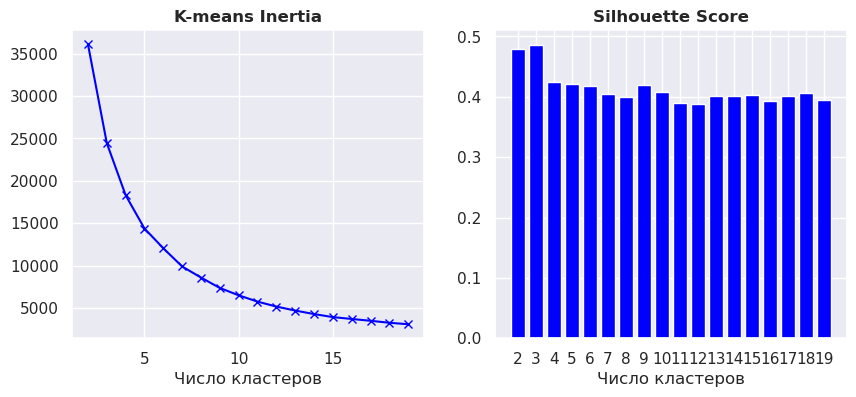

In [31]:
sns.set(font_scale=1, rc={'figure.figsize':(10,4)})

plt.subplot(1, 2, 1) # аргументы: nrows, ncols, index

plt.plot(range(2,len(inertia)+2), inertia, marker='x',color='blue') 
# первый параметр = x (число шагов= числу кластеров), второй = y (инерция)

plt.xlabel('Число кластеров')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2) # аргументы: nrows, ncols, index

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'blue')
plt.xticks(range(len(silhouette)), list(silhouette.keys())) # отметки на шкале
plt.grid(True)
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Число кластеров')


plt.show()

Возьмем **k=3** как самое оптимальное значение (чтобы кластеров было не слишком много в т.ч.)

In [32]:
kmeans = cluster.KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

clusters = kmeans.fit_predict(data_scaled[["points", "price"]])
# вычисляем центры кластеров и предугадываем номер кластера для каждого семпла данных

centroids = kmeans.cluster_centers_

display(pd.Series(clusters).value_counts()) # кол-во вин по кластерам
# kmeans_labels

/home/senya/.conda/envs/newenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    17523
1    12331
2      146
dtype: int64

Видим, что в кластер 2 попало мало данных. Увеличение количества кластеров не решает эту проблему, но 2 кластера -- тоже слишком мало. Оставим 3.

In [33]:
clusters

array([0, 1, 0, ..., 0, 0, 1], dtype=int32)

In [34]:
df_numerical["Cluster"] = clusters

In [35]:
kmeans.cluster_centers_

array([[-0.67899674, -0.32562554],
       [ 0.94068975,  0.35296342],
       [ 2.04393566,  9.27085244]])

In [36]:
df_numerical

,points,price,Cluster
21984,88,26.0,0
87522,92,80.0,1
37684,84,10.0,0
109973,92,25.0,1
751,87,13.0,0
...,...,...,...
47294,87,15.0,0
4421,89,55.0,1
7274,89,25.0,0
114807,89,26.0,0


In [37]:
import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())

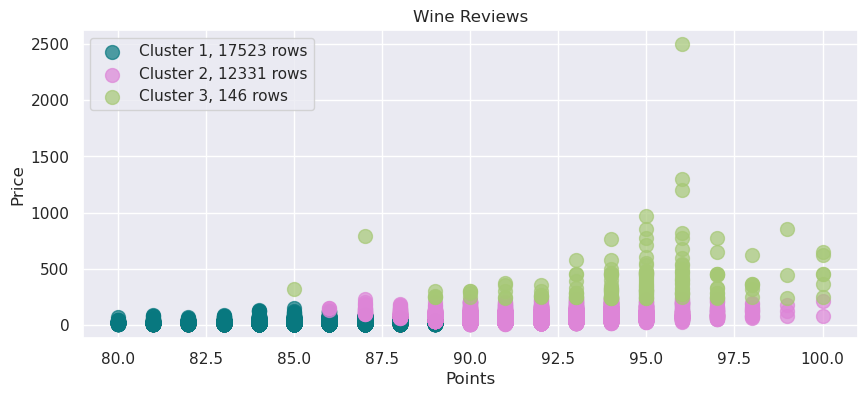

In [38]:
# Visualising the clusters

for i in range(3):
    plt.scatter(df_numerical[df_numerical["Cluster"] == i]["points"], df_numerical[df_numerical["Cluster"] == i]["price"], c = colors_list[i+30], s = 100, alpha = 0.7, label = f'Cluster {i+1}, {len(df_numerical[df_numerical["Cluster"] == i]["points"])} rows')

plt.title('Wine Reviews')
plt.xlabel('Points')
plt.ylabel('Price')
plt.legend()
plt.show()

Визуализация показывает, что кластеризация имеет какой-то смысл. Кластеры интерпретируемы по значениям price-points.

Посчитаем метрики:

In [39]:
# силуэты: определяется на промежутке [-1;1] (чем выше тем лучше)

# инерция: определяется на [0, inf) (чем ниже тем лучше)

print("Inertia score: %0.1f" % kmeans.inertia_,
     "\nSilhouette score: %0.1f" % silhouette_score(data_scaled, kmeans.labels_, metric='euclidean'))

Inertia score: 24456.9 
Silhouette score: 0.5


## AgglomerativeClustering

В агломеративной кластеризации каждому объекту припывается свой кластер и потом ближайшие кластеры постепенно объединяются, пока не получится общим супер-кластер. 

**Плюсы:** этот вид кластеризации может обработать большое количество данных <br>
**Минусы:** неудобная визуализация большого количества объектов

In [40]:
from sklearn.cluster import AgglomerativeClustering

Возьмем dataset 2, где признаков было больше.

In [41]:
X = data_scaled2.copy() # матрица признаков и их весов
cluster = AgglomerativeClustering(n_clusters=3)
cluster.fit(X)

AgglomerativeClustering(n_clusters=3)

In [42]:
Y = data.copy()
Y['Cluster'] = cluster.labels_
Y['Cluster'].value_counts() # кол-во вин по кластерам

1    12795
2     9014
0     8191
Name: Cluster, dtype: int64

Видим, что в данном случае кластеризация более сбалансирована.

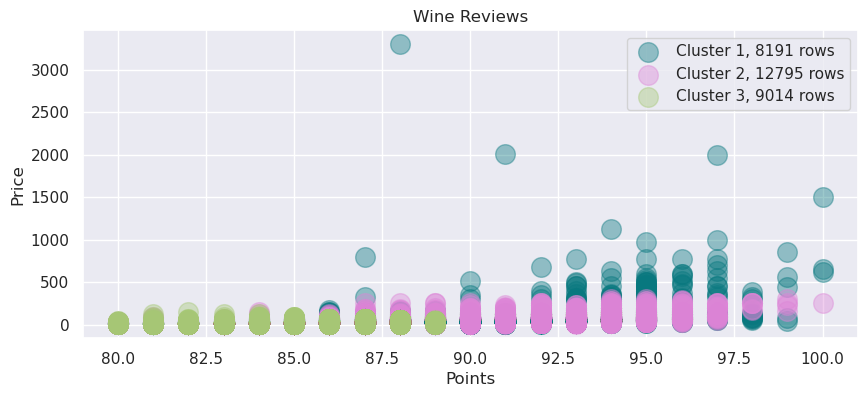

In [46]:
for i in range(3):
    plt.scatter(Y[Y["Cluster"] == i]["points"], Y[Y["Cluster"] == i]["price"], c = colors_list[i+30], s = 200, alpha = 0.4, label = f'Cluster {i+1}, {len(Y[Y["Cluster"] == i]["points"])} rows')

plt.title('Wine Reviews')
plt.xlabel('Points')
plt.ylabel('Price')
plt.legend()
plt.show()

Эта визуализация также отражает некоторую логику кластеризации. Тем не менее, ее сложнее интерпретировать, поскольку здесь учитываются только 2 признака из 3 (нет 'country_encoded').

In [47]:
from sklearn import metrics

In [48]:
print("Silhouette score:", round(metrics.silhouette_score(X, cluster.labels_), 2))

Silhouette score: 0.36


**Вывод**: мы попробовали 2 алгоритма кластеризации -- KMeans на числовых данных и AgglomerativeClustering на числовых данных + один категориальный признак. 

Несмотря на то, что silhouette score выше у KMeans, AgglomerativeClustering предлагает более сбалансированную кластеризацию.